In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from IPython.display import Image

colors = ["coral", "peru", "limegreen", "turquoise", "dodgerblue", "orchid"]
sns.set_palette(colors)

In [2]:
def get_date_from_year_and_week(row):
    """Create date from year and week.

    We take the Sunday of each week.

    """
    date = datetime.date.fromisocalendar(
        year=int(row["year"]), week=int(row["week"]), day=7
    )
    return pd.Timestamp(date)


In [3]:
ars = pd.read_excel("ars_data_raw.xlsx")
ars = ars[ars["year"].notnull()]
keep_cols = [
    "age_group", "n_tests", "pct_of_tests_positive", "n_tests_per_100_000", 
    "n_positive_tests_per_100_000", "week", "year"
]
ars = ars[keep_cols]
assert ars.notnull().all().all()

ars["date"] = ars.apply(get_date_from_year_and_week, axis=1)
ars["share_tests_positive"] = ars["pct_of_tests_positive"] / 100
ars["n_positive_tests"] = ars["n_tests"] * ars["share_tests_positive"]
ars["age_group"] = pd.Categorical(
    ars["age_group"], 
    ordered=True, 
    categories=["0-4", "5-14", "15-34", "35-59", "60-79", ">=80"]
)

ars.to_csv("ars_cleaned_weekly.csv")

In [4]:
first_part = ars[ars["week"].between(38, 49)].copy(deep=True)
second_part = ars[ars["date"] > pd.Timestamp("2020-11-25")].copy(deep=True)

In [5]:
rki_n_tests = pd.read_csv('rki/n_tests.csv', parse_dates=["date"])
rki_n_tests["week"] = rki_n_tests["date"].dt.week

rki_n_positive_tests = pd.read_csv('rki/n_positive_tests.csv', parse_dates=["date"])
rki_n_positive_tests["week"] = rki_n_positive_tests["date"].dt.week

rki_pct_positive = 100 * rki_n_positive_tests["n_positive_tests"] / rki_n_tests["n_tests"]
rki_pct_positive.index = rki_n_positive_tests["date"]

weights = pd.read_pickle("age_groups_rki.pkl")["weight"]
population = pd.read_pickle("age_groups_rki.pkl")["n"]
population.index.name = "age_group"
population.index = population.index.rename_categories({"80-100": ">=80"})

# Compare Number of Tests 

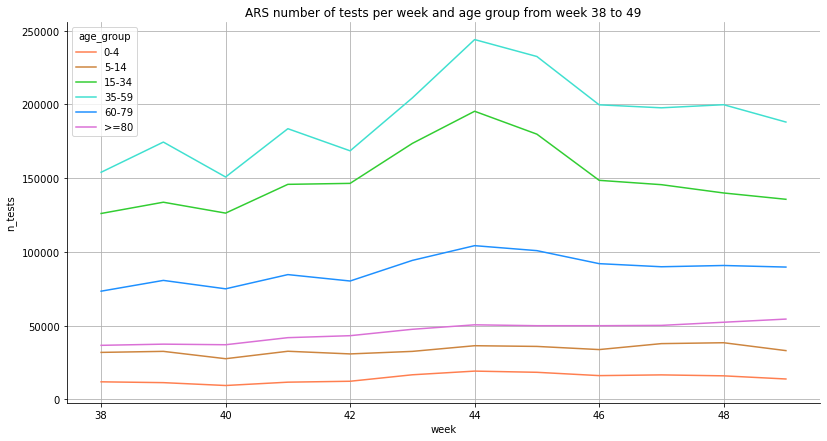

In [6]:
fig, ax = plt.subplots(figsize=(13.5, 7))
sns.lineplot(data=first_part, x="week", y="n_tests", hue="age_group")
ax.grid()
ax.set_title("ARS number of tests per week and age group from week 38 to 49")
sns.despine()

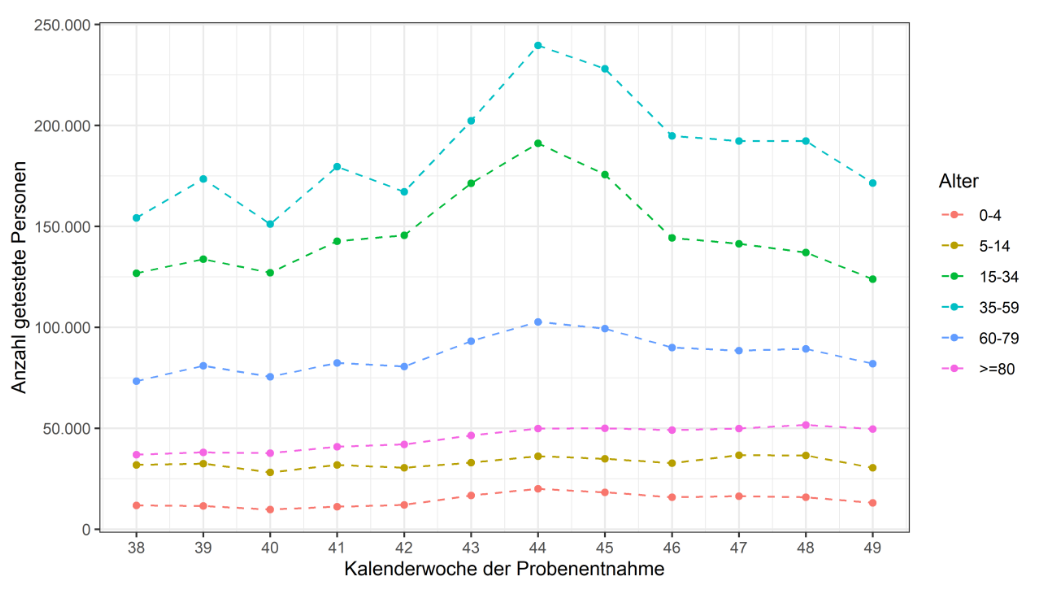

In [7]:
# ignore the last three weeks because of delayed reporting!
Image(filename='ars_n_tests_w38-w49.png') 

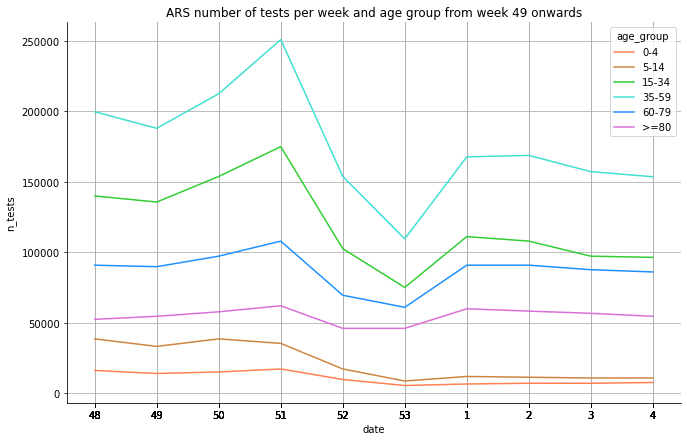

In [8]:
fig, ax = plt.subplots(figsize=(11, 7))
sns.lineplot(data=second_part, x="date", y="n_tests", hue="age_group")
ax.grid()
ax.set_title("ARS number of tests per week and age group from week 49 onwards")
plt.xticks(second_part["date"], second_part["week"])
sns.despine()

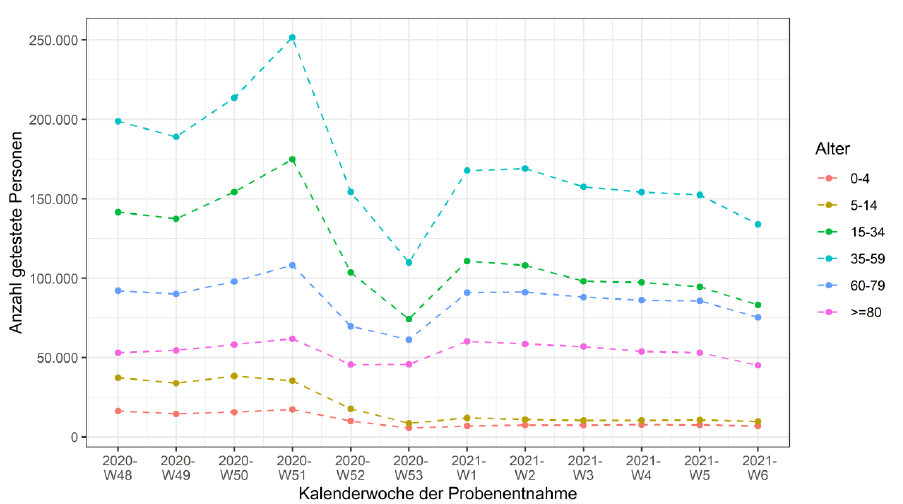

In [9]:
Image(filename='ars_n_tests_w48-w06.png') 

## Compare to RKI number of tests overall 

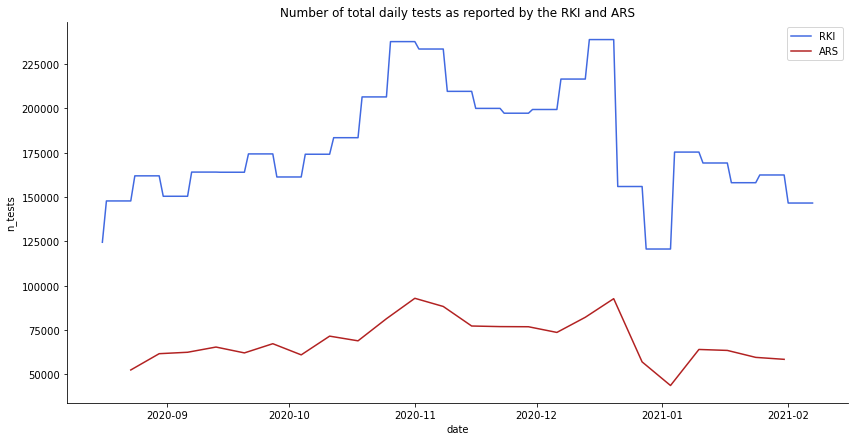

In [10]:
daily_ars_n_tests = ars.groupby('date')["n_tests"].sum() / 7

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(data=rki_n_tests, x="date", y="n_tests", label="RKI", color="royalblue")
sns.lineplot(x=daily_ars_n_tests.index, y=daily_ars_n_tests, label="ARS", color="firebrick")
ax.set_title("Number of total daily tests as reported by the RKI and ARS")
sns.despine()

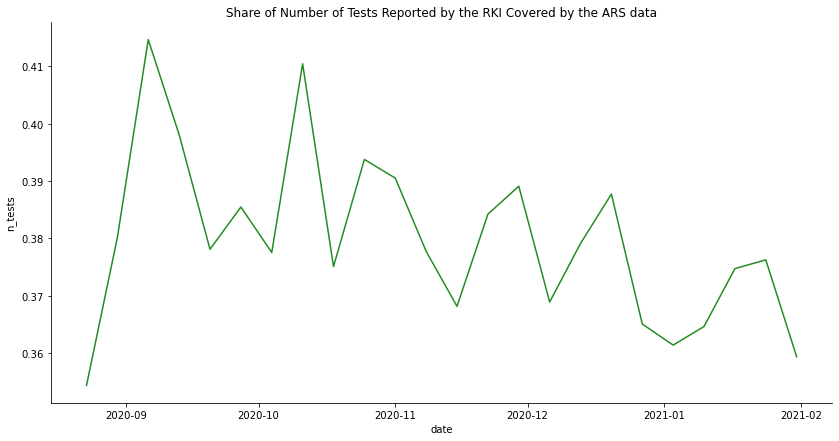

In [11]:
ars_coverage = (daily_ars_n_tests / rki_n_tests.set_index('date')["n_tests"]).dropna()
fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x=ars_coverage.index, y=ars_coverage, color="forestgreen")
ax.set_title("Share of Number of Tests Reported by the RKI Covered by the ARS data")
sns.despine()

# Compare Percentage of Positive Tests

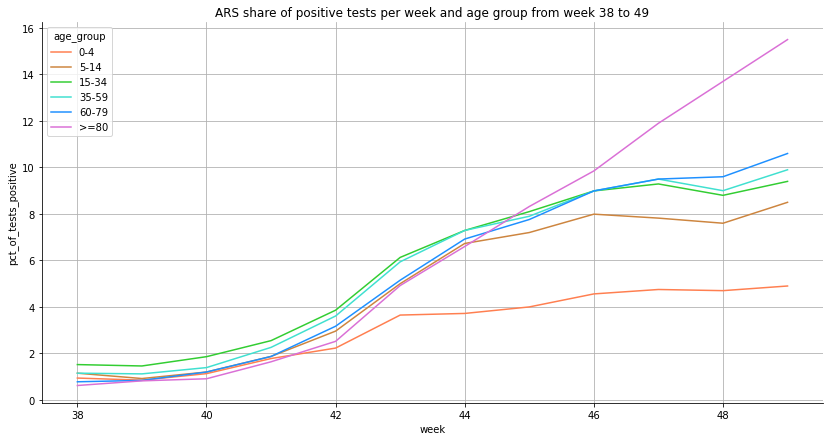

In [12]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(data=first_part, x="week", y="pct_of_tests_positive", hue="age_group")
ax.grid()
ax.set_title("ARS share of positive tests per week and age group from week 38 to 49")
sns.despine()

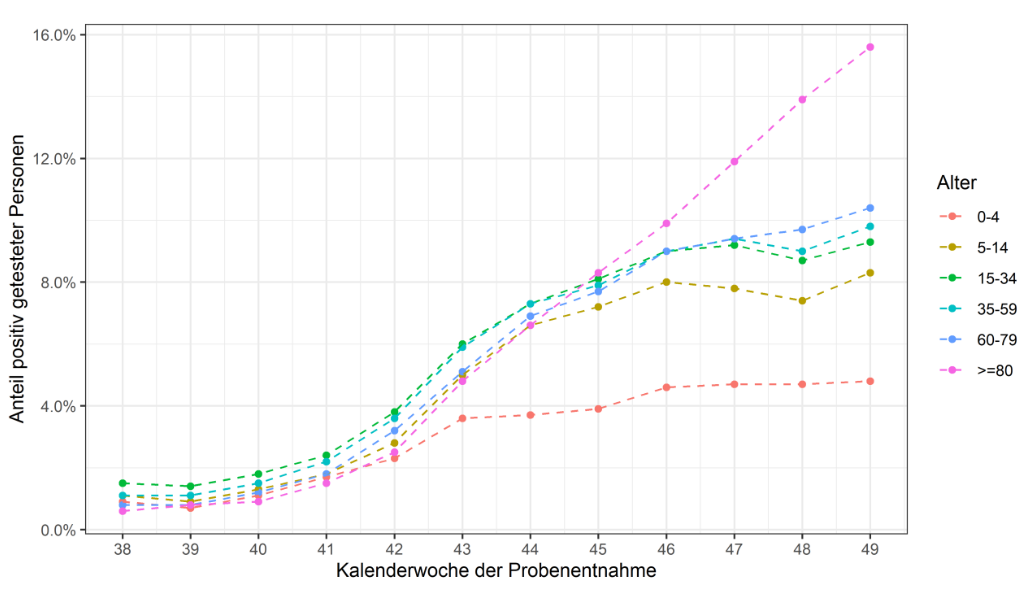

In [13]:
Image(filename='ars_pct_positive_w38-w49.png')

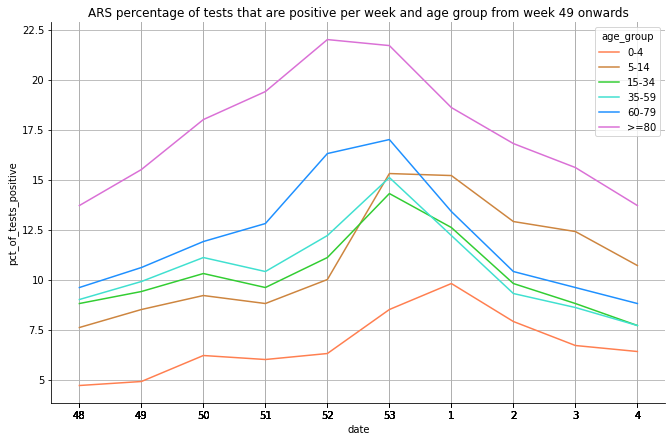

In [14]:
fig, ax = plt.subplots(figsize=(11, 7))
sns.lineplot(data=second_part, x="date", y="pct_of_tests_positive", hue="age_group")
ax.grid()
ax.set_title("ARS percentage of tests that are positive per week and age group from week 49 onwards")
plt.xticks(second_part["date"], second_part["week"])
yticks = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5]
plt.yticks(yticks, yticks)
sns.despine()

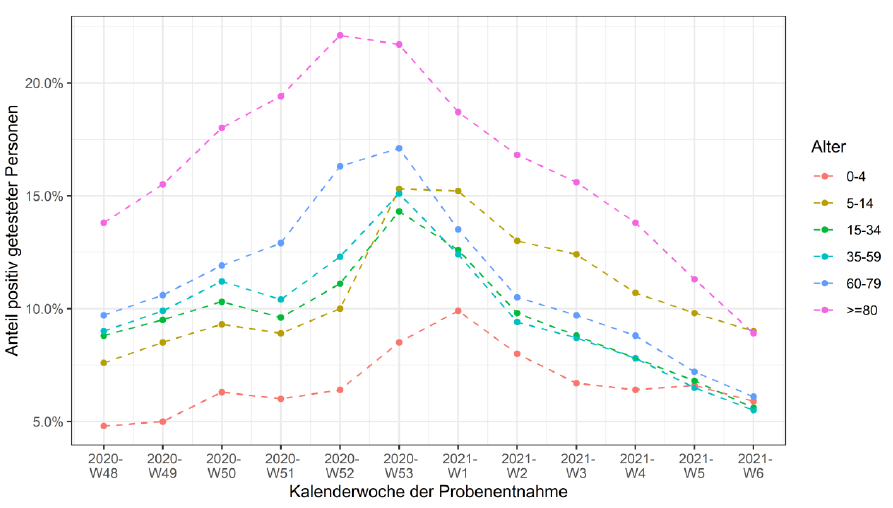

In [15]:
Image(filename='ars_pct_positive_w48-w06.png')

## Compare to RKI

In [16]:
def weighted_mean(sr, weights=weights):
    date = sr.index.get_level_values("date")[0]
    sr = sr.loc[date]
    return (sr * weights).sum()

ars_avg_positive = ars.set_index(["date", "age_group"]).groupby('date')["pct_of_tests_positive"].apply(weighted_mean)

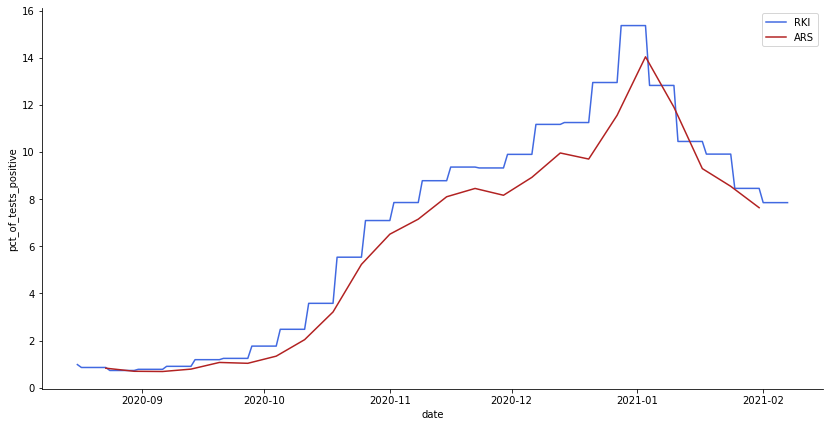

In [17]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x=rki_pct_positive.index, y=rki_pct_positive, label="RKI", color="royalblue")
sns.lineplot(x=ars_avg_positive.index, y=ars_avg_positive, label="ARS", color="firebrick")
sns.despine()

# Some tests on the data

In [18]:
ars = ars.reset_index()
ars = ars.set_index(["date", "age_group"])
ars["n_tests_per_100_000_calculated"] = 100_000 * (ars["n_tests"] / population)
ars["n_positive_tests_per_100_000_calculated"] = 100_000 * ars["n_positive_tests"] / population
ars = ars.reset_index()

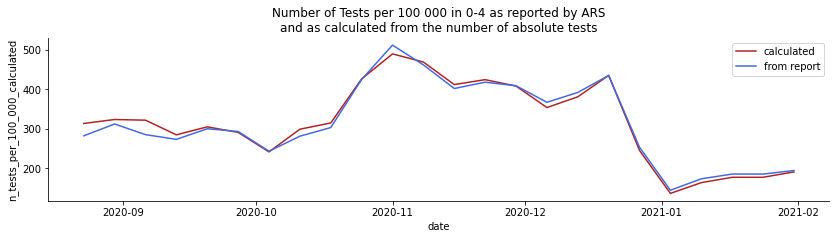

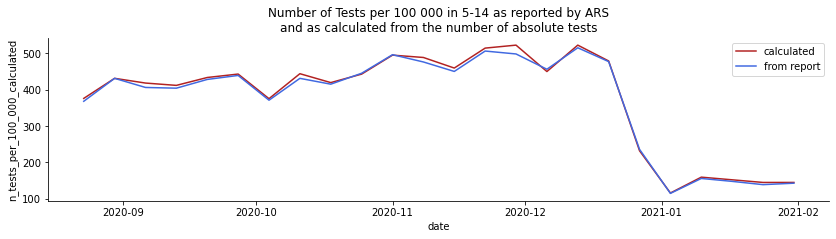

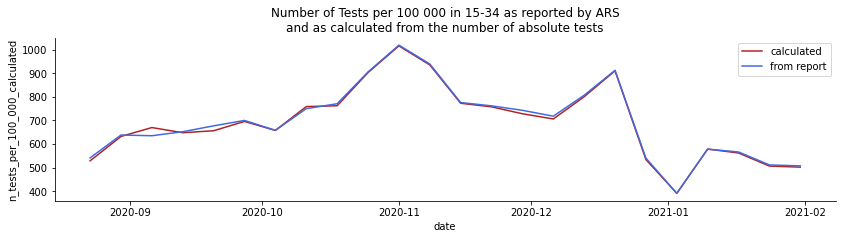

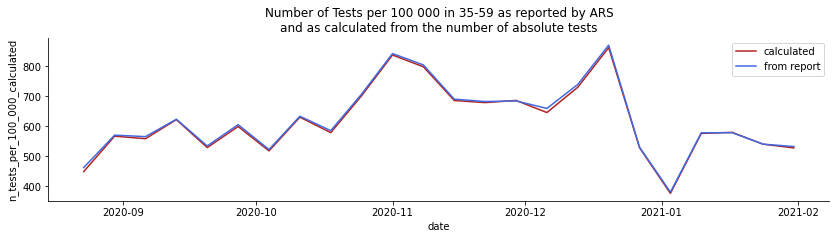

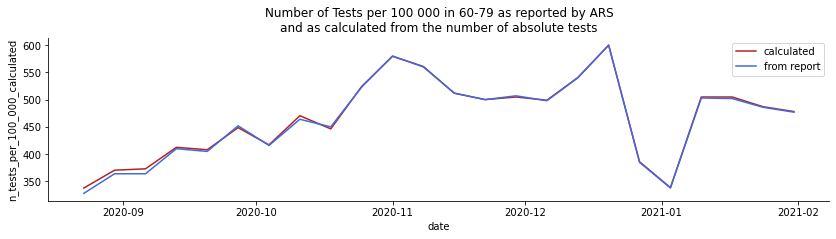

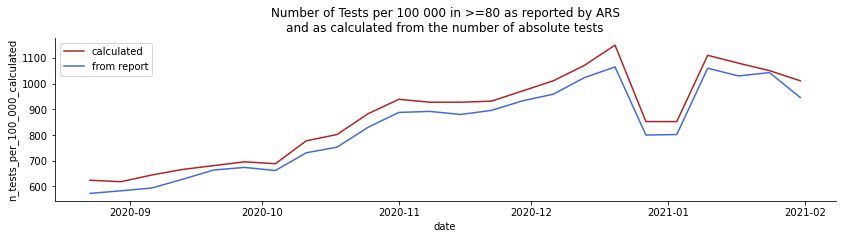

In [19]:
for age_group in ars["age_group"].unique():
    df = ars[ars["age_group"] == age_group]
    fig, ax = plt.subplots(figsize=(14, 3))
    sns.lineplot(data=df, x="date", y="n_tests_per_100_000_calculated", label="calculated", color="firebrick")
    sns.lineplot(data=df, x="date", y="n_tests_per_100_000", label="from report", color="royalblue")
    ax.set_title(
        f"Number of Tests per 100 000 in {age_group} as reported by ARS\n" 
        "and as calculated from the number of absolute tests")
    sns.despine()

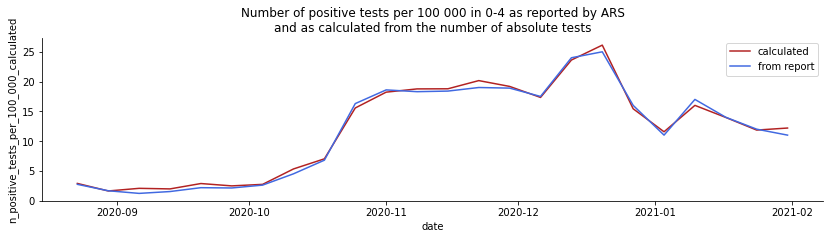

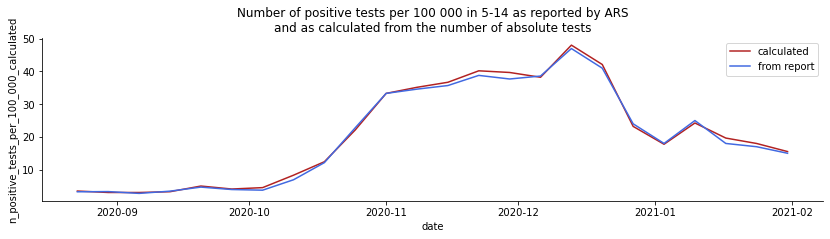

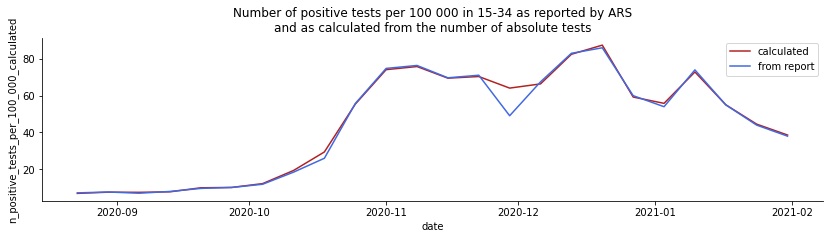

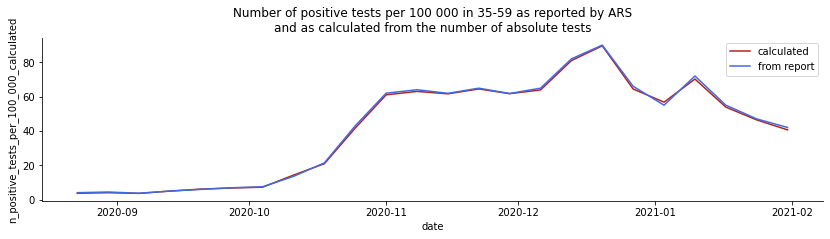

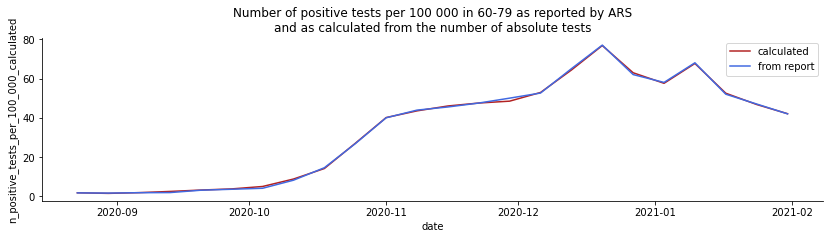

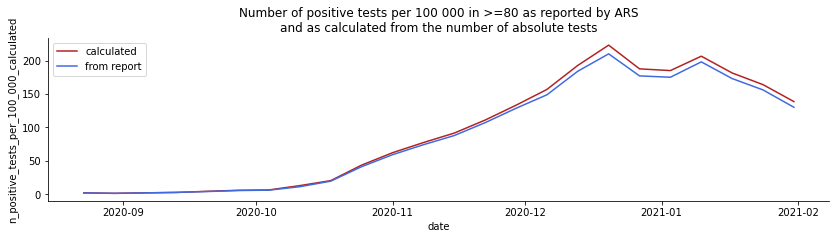

In [20]:
for age_group in ars["age_group"].unique():
    df = ars[ars["age_group"] == age_group]
    fig, ax = plt.subplots(figsize=(14, 3))
    sns.lineplot(data=df, x="date", y="n_positive_tests_per_100_000_calculated", label="calculated", color="firebrick")
    sns.lineplot(data=df, x="date", y="n_positive_tests_per_100_000", label="from report", color="royalblue")
    ax.set_title(
        f"Number of positive tests per 100 000 in {age_group} as reported by ARS\n" 
        "and as calculated from the number of absolute tests")
    sns.despine()